# 1. 라이브러리 임포트

In [1]:
import json
import os
import pandas as pd
from PIL import Image,ImageOps,ImageDraw
import numpy as np
import warnings
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import cv2
from statistics import median

warnings.filterwarnings(action='ignore')

In [2]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 50.6 MB/s eta 0:00:00


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


# 2. 데이터 불러오기 및 데이터프레임 생성하기

In [4]:
label_path = '/content/drive/MyDrive/Data/label'
train_label_path = os.path.join(label_path,'train')
val_label_path = os.path.join(label_path,'val')
label_json_list = ['anger.json','happy.json','panic.json','sadness.json']

In [5]:
train_seg_path = '/content/drive/MyDrive/Data/segmentation/train/'
val_seg_path = '/content/drive/MyDrive/Data/segmentation/val/'

In [6]:
train_df = pd.DataFrame(columns=['img_path','age', 'gender', 'isProf', 'background', 'maxX','maxY','minX','minY','label'])
val_df = pd.DataFrame(columns=['img_path','age', 'gender', 'isProf', 'background', 'maxX','maxY','minX','minY','label'])

In [7]:
image_path = '/content/drive/MyDrive/Data/img'
train_path = os.path.join(image_path, 'train')
val_path = os.path.join(image_path, 'val')

In [8]:
train_path_anger = os.path.join(train_path, 'anger')
train_path_happy = os.path.join(train_path, 'happy')
train_path_panic = os.path.join(train_path, 'panic')
train_path_sadness = os.path.join(train_path, 'sadness')

In [9]:
train_path_anger = os.listdir(train_path_anger)
train_path_happy = os.listdir(train_path_happy)
train_path_panic = os.listdir(train_path_panic)
train_path_sadness = os.listdir(train_path_sadness)

In [10]:
print(len(list(train_path_anger)))
print(len(list(train_path_happy)))
print(len(list(train_path_panic)))
print(len(list(train_path_sadness)))

1500
1495
1501
1500


In [11]:
import json
def makedf(dir_path, df, data_path):
    i = 0
    data_name = dir_path.split('/')[-1]
    label_json_list = [file.split('_')[-1] for file in os.listdir(dir_path) if file.startswith(data_name + '_')]

    for label_name in label_json_list:
        with open(os.path.join(dir_path, data_name + '_' + label_name), 'r', encoding='cp949') as f:
            file = json.load(f)
        for v in file:
            if v['faceExp_uploader'] == '분노':
                label = 'anger'
            elif v['faceExp_uploader'] == '기쁨':
                label = 'happy'
            elif v['faceExp_uploader'] == '당황':
                label = 'panic'
            elif v['faceExp_uploader'] == '슬픔':
                label = 'sadness'

            minX = median([v['annot_A']['boxes']['minX'], v['annot_B']['boxes']['minX'], v['annot_C']['boxes']['minX']])
            minY = median([v['annot_A']['boxes']['minY'], v['annot_B']['boxes']['minY'], v['annot_C']['boxes']['minY']])
            maxX = median([v['annot_A']['boxes']['maxX'], v['annot_B']['boxes']['maxX'], v['annot_C']['boxes']['maxX']])
            maxY = median([v['annot_A']['boxes']['maxY'], v['annot_B']['boxes']['maxY'], v['annot_C']['boxes']['maxY']])

            result_path = os.path.join(data_path, label)
            df.loc[i] = [os.path.join(result_path, v['filename']), v['age'], v['gender'], v['isProf'], v['bg_uploader'], int(maxX), int(maxY), int(minX), int(minY), label]
            i += 1

    return df.sample(frac=1, random_state=42).reset_index(drop=True)

In [12]:
train_df = makedf(train_label_path, train_df, train_path)
val_df = makedf(val_label_path, val_df, val_path)

# 3. EDA

In [13]:
train_df.head()

,img_path,age,gender,isProf,background,maxX,maxY,minX,minY,label
0,/content/drive/MyDrive/Data/img/train/happy/nd...,20,남,전문인,스포츠 관람 및 레저시설,2113,1887,1173,628,happy
1,/content/drive/MyDrive/Data/img/train/happy/w3...,20,남,일반인,교통/이동수단(엘리베이터 포함),1814,1197,932,146,happy
2,/content/drive/MyDrive/Data/img/train/happy/y9...,20,여,일반인,공공시설/종교/의료시설,3156,2007,2239,734,happy
3,/content/drive/MyDrive/Data/img/train/happy/pv...,20,남,일반인,숙박 및 거주공간,2265,2252,1244,990,happy
4,/content/drive/MyDrive/Data/img/train/happy/7p...,30,여,일반인,도심 환경,2423,1321,1682,313,happy


In [14]:
train_df.tail()

,img_path,age,gender,isProf,background,maxX,maxY,minX,minY,label
5989,/content/drive/MyDrive/Data/img/train/panic/3f...,20,여,전문인,오락/공연시설,2174,1478,1308,302,panic
5990,/content/drive/MyDrive/Data/img/train/anger/n9...,20,여,전문인,문화재 및 유적지,1973,1976,945,565,anger
5991,/content/drive/MyDrive/Data/img/train/anger/6f...,20,여,전문인,공공시설/종교/의료시설,2061,1582,1280,606,anger
5992,/content/drive/MyDrive/Data/img/train/anger/t2...,20,남,전문인,문화재 및 유적지,985,1485,488,801,anger
5993,/content/drive/MyDrive/Data/img/train/sadness/...,30,여,일반인,숙박 및 거주공간,1235,1333,372,210,sadness


In [15]:
train_df[(train_df['minX'] < 0) | (train_df['minY'] < 0) | (train_df['maxX'] < 100) | (train_df['maxY'] < 130)]

,img_path,age,gender,isProf,background,maxX,maxY,minX,minY,label
172,/content/drive/MyDrive/Data/img/train/sadness/...,30,여,일반인,공공시설/종교/의료시설,361,386,-2,-102,sadness
200,/content/drive/MyDrive/Data/img/train/anger/br...,20,남,일반인,도심 환경,1582,709,1001,-81,anger
316,/content/drive/MyDrive/Data/img/train/panic/4h...,40,여,일반인,공공시설/종교/의료시설,863,1585,-27,462,panic
1594,/content/drive/MyDrive/Data/img/train/anger/9r...,20,여,일반인,상업시설/점포/시장,1493,672,870,-204,anger
3837,/content/drive/MyDrive/Data/img/train/happy/34...,20,남,일반인,공공시설/종교/의료시설,965,857,261,-20,happy


In [16]:
val_df[(val_df['minX'] < 0) | (val_df['minY'] < 0) | (val_df['maxX'] < 100) | (val_df['maxY'] < 130)]

,img_path,age,gender,isProf,background,maxX,maxY,minX,minY,label


In [17]:
train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5994 entries, 0 to 5993
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   img_path    5994 non-null   object
 1   age         5994 non-null   int64 
 2   gender      5994 non-null   object
 3   isProf      5994 non-null   object
 4   background  5994 non-null   object
 5   maxX        5994 non-null   int64 
 6   maxY        5994 non-null   int64 
 7   minX        5994 non-null   int64 
 8   minY        5994 non-null   int64 
 9   label       5994 non-null   object
dtypes: int64(5), object(5)
memory usage: 3.4 MB


In [18]:
train_df.isna().sum()

img_path      0
age           0
gender        0
isProf        0
background    0
maxX          0
maxY          0
minX          0
minY          0
label         0
dtype: int64

In [19]:
train_df.shape

(5994, 10)

In [20]:
train_df.describe()

,age,maxX,maxY,minX,minY
count,5994.000000,5994.000000,5994.000000,5994.000000,5994.000000
mean,26.359693,1999.226560,1568.735235,1183.334668,466.228562
std,8.142815,551.201881,361.098070,463.869348,227.556511
min,10.000000,361.000000,386.000000,-27.000000,-204.000000
25%,20.000000,1680.000000,1357.000000,899.000000,303.000000
50%,20.000000,1972.000000,1566.000000,1144.000000,440.000000
75%,30.000000,2316.000000,1766.000000,1465.000000,603.000000
max,60.000000,6173.000000,4488.000000,3947.000000,1769.000000


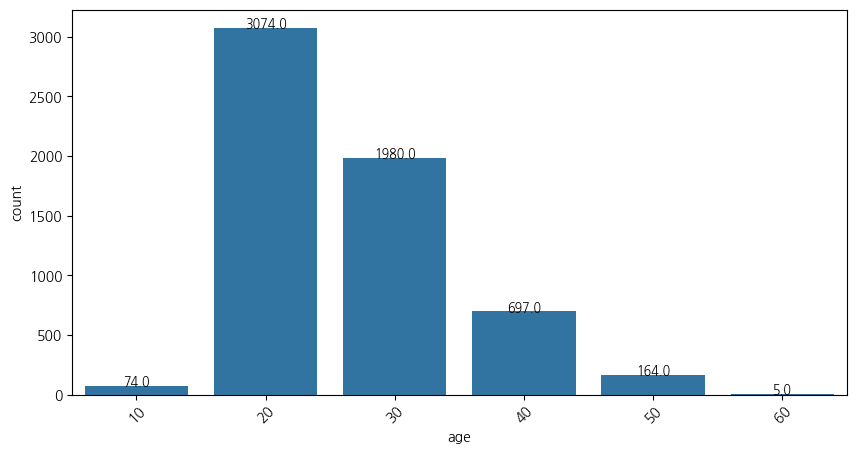

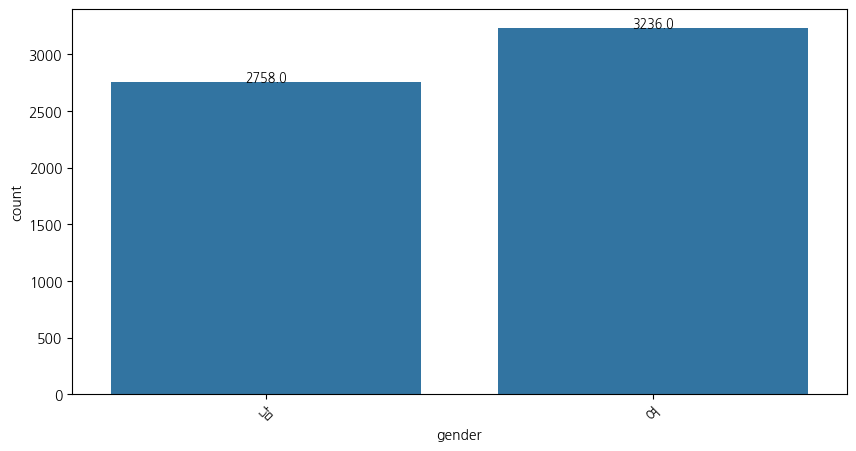

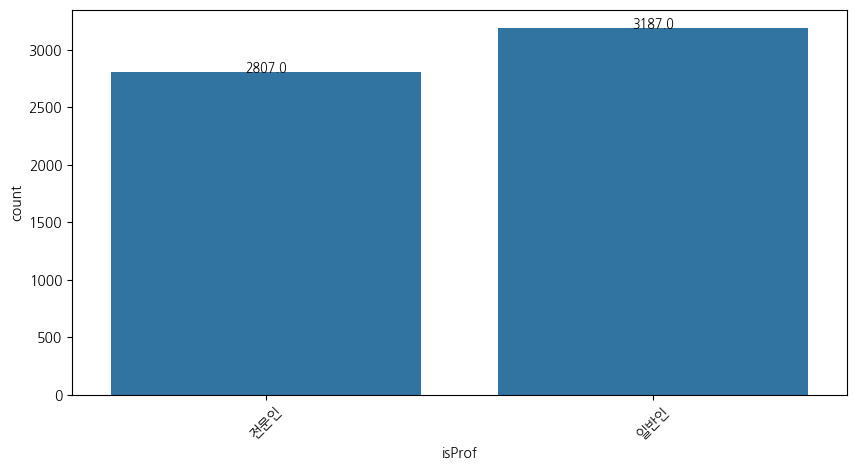

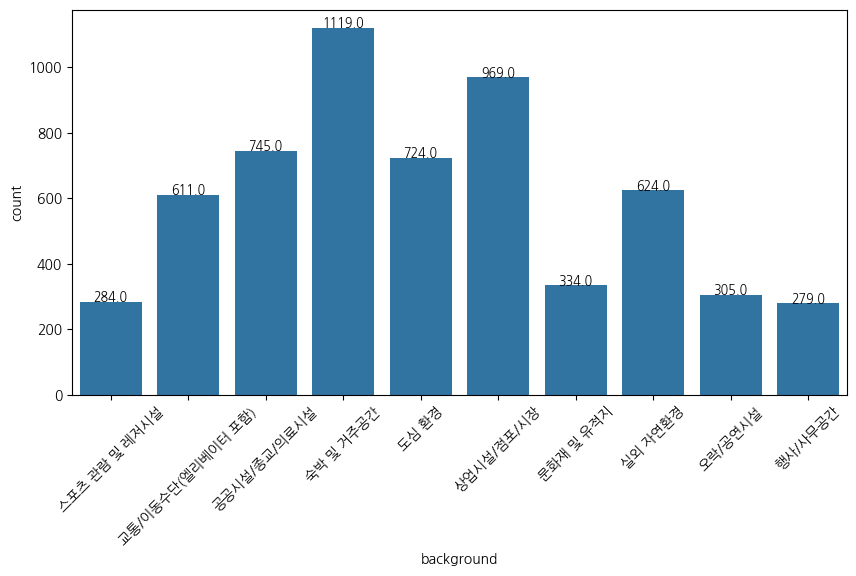

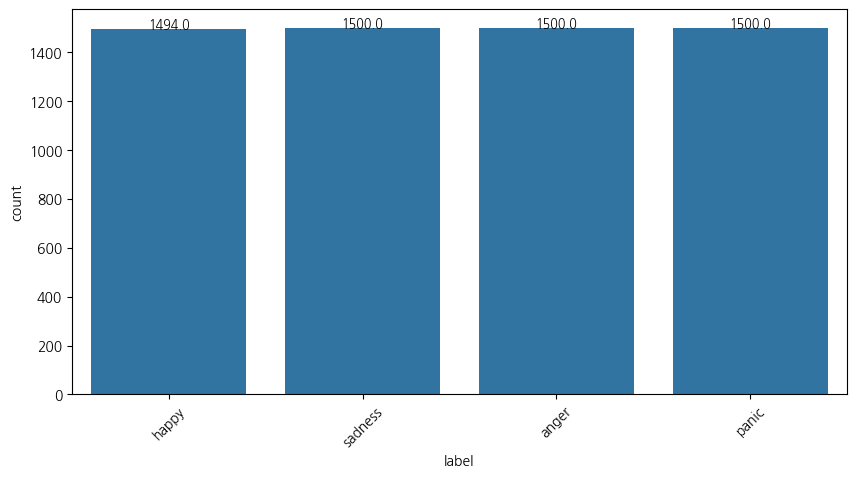

In [21]:
col_list = ['age', 'gender', 'isProf', 'background', 'label']
for col in col_list:
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(x=train_df[col])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
    plt.show()

# 4. Image Preprocessing

## 4-1. crop

In [22]:
crop_save_path = '/content/drive/MyDrive/preprocessed_crop'
crop_train_dir = os.path.join(crop_save_path, 'train')
crop_val_dir = os.path.join(crop_save_path, 'val')

In [23]:
def image_preprocessed_crop(file_path, bound):
    img = cv2.imread(file_path)
    preprocessed = img[bound[0]:bound[1], bound[2]:bound[3]]

    return preprocessed

In [ ]:
for i in range(len(train_df)):
        min_x = int(max((train_df.loc[i, 'minX']), 0))
        min_y = int(max((train_df.loc[i, 'minY']), 0))
        max_x = int(max((train_df.loc[i, 'maxX']), 0))
        max_y = int(max((train_df.loc[i, 'maxY']), 0))
        bound = (min_y, max_y, min_x, max_x)
        print(f"Processing image {train_df['img_path'][i]} with bounds {bound}")

        label_dir = os.path.join(crop_train_dir, train_df['label'][i])
        os.makedirs(label_dir, exist_ok=True)
        img_name = os.path.basename(train_df['img_path'][i])
        output_path = os.path.join(label_dir, img_name)

        cv2.imwrite(output_path, image_preprocessed_crop(train_df['img_path'][i], bound))
        print(f"Saved processed image to {output_path}")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Processing image /content/drive/MyDrive/Data/img/train/panic/6w4d191a1004f3f598570868a94edfa73a5e55655fd47f16f1af04488a866ke3h.jpg with bounds (882, 2022, 1351, 2161)
Saved processed image to /content/drive/MyDrive/preprocessed_crop/train/panic/6w4d191a1004f3f598570868a94edfa73a5e55655fd47f16f1af04488a866ke3h.jpg
Processing image /content/drive/MyDrive/Data/img/train/anger/ougk6fc53dd01f569f94956c1f6a1f0ff70a987996f6fd85c5c5f448f0baag5cg.jpg with bounds (784, 2272, 1466, 2577)
Saved processed image to /content/drive/MyDrive/preprocessed_crop/train/anger/ougk6fc53dd01f569f94956c1f6a1f0ff70a987996f6fd85c5c5f448f0baag5cg.jpg
Processing image /content/drive/MyDrive/Data/img/train/anger/n7jlc06aa011e1601774ff620c4c7411f7c130bc670ee07a28181b21f8017atgt.jpg with bounds (736, 1386, 1095, 1609)
Saved processed image to /content/drive/MyDrive/preprocessed_crop/train/anger/n7jlc06aa011e1601774ff620c4c7411f7c130bc670ee07a28181b21f8017atgt.jpg
Processing image /c

In [ ]:
for i in range(len(val_df)):
        min_x = int(max((val_df.loc[i, 'minX']), 0))
        min_y = int(max((val_df.loc[i, 'minY']), 0))
        max_x = int(max((val_df.loc[i, 'maxX']), 0))
        max_y = int(max((val_df.loc[i, 'maxY']), 0))
        bound = (min_y, max_y, min_x, max_x)
        print(f"Processing image {val_df['img_path'][i]} with bounds {bound}")

        label_dir = os.path.join(crop_val_dir, val_df['label'][i])
        os.makedirs(label_dir, exist_ok=True)
        img_name = os.path.basename(val_df['img_path'][i])
        output_path = os.path.join(label_dir, img_name)

        cv2.imwrite(output_path, image_preprocessed_crop(val_df['img_path'][i], bound))
        print(f"Saved processed image to {output_path}")

Processing image /content/drive/MyDrive/Data/img/val/happy/jgsebbdce6508e96e33bd68edebc0b5c5ab3e5e0c8d0838d8bbcb735c185dz4bz.jpg with bounds (439, 1576, 682, 1447)
Saved processed image to /content/drive/MyDrive/preprocessed_crop/val/happy/jgsebbdce6508e96e33bd68edebc0b5c5ab3e5e0c8d0838d8bbcb735c185dz4bz.jpg
Processing image /content/drive/MyDrive/Data/img/val/panic/pjhh872b8819c39acbd961a992118a493961b246aa2c002192978876470965kbp.jpg with bounds (262, 1665, 1638, 2663)
Saved processed image to /content/drive/MyDrive/preprocessed_crop/val/panic/pjhh872b8819c39acbd961a992118a493961b246aa2c002192978876470965kbp.jpg
Processing image /content/drive/MyDrive/Data/img/val/sadness/u0i4215999e63907057bca0ec940afa4e589949e8e0aa071ec85500a6d785tnp3.jpg with bounds (132, 1333, 706, 1568)
Saved processed image to /content/drive/MyDrive/preprocessed_crop/val/sadness/u0i4215999e63907057bca0ec940afa4e589949e8e0aa071ec85500a6d785tnp3.jpg
Processing image /content/drive/MyDrive/Data/img/val/anger/pm2m73

## 4-2. crop + segmentation

In [ ]:
seg_save_path = '/content/drive/MyDrive/preprocessed_seg'
seg_train_dir = os.path.join(seg_save_path, 'train')
seg_val_dir = os.path.join(seg_save_path, 'val')

In [ ]:
def image_preprocessed_seg(name, seg_path, file_path, label, bound):
    npz = np.load(seg_path + f'{name}_{label}.npz')
    file_name = file_path.split('/')[-1]
    segment = npz[file_name]

    img = cv2.imread(file_path)
    img[segment != 3] = 0
    preprocessed = img[bound[0]:bound[1], bound[2]:bound[3]]

    return preprocessed

In [ ]:
def image_preprocessing(df, dir):
    for i in range(len(df)):
        min_x = int(max((df.loc[i, 'minX']), 0))
        min_y = int(max((df.loc[i, 'minY']), 0))
        max_x = int(max((df.loc[i, 'maxX']), 0))
        max_y = int(max((df.loc[i, 'maxY']), 0))
        bound = (min_y, max_y, min_x, max_x)
        print(f"Processing image {df['img_path'][i]} with bounds {bound}")
        label_dir = os.path.join(seg_train_dir, df['label'][i])
        os.makedirs(label_dir, exist_ok=True)
        img_name = os.path.basename(df['img_path'][i])
        output_path = os.path.join(label_dir, img_name)
        cv2.imwrite(output_path, image_preprocessed_seg('train', train_seg_path, df['img_path'][i], df['label'][i], bound))
        print(f"Saved processed image to {output_path}")
for df in [train_df, val_df]:
    image_preprocessing(df)

In [ ]:
for i in range(len(train_df)):
        min_x = int(max((train_df.loc[i, 'minX']), 0))
        min_y = int(max((train_df.loc[i, 'minY']), 0))
        max_x = int(max((train_df.loc[i, 'maxX']), 0))
        max_y = int(max((train_df.loc[i, 'maxY']), 0))
        bound = (min_y, max_y, min_x, max_x)
        print(f"Processing image {train_df['img_path'][i]} with bounds {bound}")

        label_dir = os.path.join(crop_train_dir, train_df['label'][i])
        os.makedirs(label_dir, exist_ok=True)
        img_name = os.path.basename(train_df['img_path'][i])
        output_path = os.path.join(label_dir, img_name)

        cv2.imwrite(output_path, image_preprocessed_crop(train_df['img_path'][i], bound))
        print(f"Saved processed image to {output_path}")

In [ ]:
for i in range(len(train_df)):
        min_x = int(max((train_df.loc[i, 'minX']), 0))
        min_y = int(max((train_df.loc[i, 'minY']), 0))
        max_x = int(max((train_df.loc[i, 'maxX']), 0))
        max_y = int(max((train_df.loc[i, 'maxY']), 0))
        bound = (min_y, max_y, min_x, max_x)
        print(f"Processing image {train_df['img_path'][i]} with bounds {bound}")

        label_dir = os.path.join(seg_train_dir, train_df['label'][i])
        os.makedirs(label_dir, exist_ok=True)
        img_name = os.path.basename(train_df['img_path'][i])
        output_path = os.path.join(label_dir, img_name)

        cv2.imwrite(output_path, image_preprocessed_seg('train', train_seg_path, train_df['img_path'][i], train_df['label'][i], bound))
        print(f"Saved processed image to {output_path}")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Processing image /content/drive/MyDrive/Data/img/train/panic/6w4d191a1004f3f598570868a94edfa73a5e55655fd47f16f1af04488a866ke3h.jpg with bounds (882, 2022, 1351, 2161)
Saved processed image to /content/drive/MyDrive/preprocessed/train/panic/6w4d191a1004f3f598570868a94edfa73a5e55655fd47f16f1af04488a866ke3h.jpg
Processing image /content/drive/MyDrive/Data/img/train/anger/ougk6fc53dd01f569f94956c1f6a1f0ff70a987996f6fd85c5c5f448f0baag5cg.jpg with bounds (784, 2272, 1466, 2577)
Saved processed image to /content/drive/MyDrive/preprocessed/train/anger/ougk6fc53dd01f569f94956c1f6a1f0ff70a987996f6fd85c5c5f448f0baag5cg.jpg
Processing image /content/drive/MyDrive/Data/img/train/anger/n7jlc06aa011e1601774ff620c4c7411f7c130bc670ee07a28181b21f8017atgt.jpg with bounds (736, 1386, 1095, 1609)
Saved processed image to /content/drive/MyDrive/preprocessed/train/anger/n7jlc06aa011e1601774ff620c4c7411f7c130bc670ee07a28181b21f8017atgt.jpg
Processing image /content/drive/My

In [ ]:
for i in range(len(val_df)):
        min_x = int(max((val_df.loc[i, 'minX']), 0))
        min_y = int(max((val_df.loc[i, 'minY']), 0))
        max_x = int(max((val_df.loc[i, 'maxX']), 0))
        max_y = int(max((val_df.loc[i, 'maxY']), 0))
        bound = (min_y, max_y, min_x, max_x)
        print(f"Processing image {val_df['img_path'][i]} with bounds {bound}")

        label_dir = os.path.join(seg_val_dir, val_df['label'][i])
        os.makedirs(label_dir, exist_ok=True)
        img_name = os.path.basename(val_df['img_path'][i])
        output_path = os.path.join(label_dir, img_name)

        cv2.imwrite(output_path, image_preprocessed_seg('val', val_seg_path, val_df['img_path'][i], val_df['label'][i], bound))
        print(f"Saved processed image to {output_path}")

Processing image /content/drive/MyDrive/Data/img/val/happy/jgsebbdce6508e96e33bd68edebc0b5c5ab3e5e0c8d0838d8bbcb735c185dz4bz.jpg with bounds (439, 1576, 682, 1447)
Saved processed image to /content/drive/MyDrive/preprocessed/val/happy/jgsebbdce6508e96e33bd68edebc0b5c5ab3e5e0c8d0838d8bbcb735c185dz4bz.jpg
Processing image /content/drive/MyDrive/Data/img/val/panic/pjhh872b8819c39acbd961a992118a493961b246aa2c002192978876470965kbp.jpg with bounds (262, 1665, 1638, 2663)
Saved processed image to /content/drive/MyDrive/preprocessed/val/panic/pjhh872b8819c39acbd961a992118a493961b246aa2c002192978876470965kbp.jpg
Processing image /content/drive/MyDrive/Data/img/val/sadness/u0i4215999e63907057bca0ec940afa4e589949e8e0aa071ec85500a6d785tnp3.jpg with bounds (132, 1333, 706, 1568)
Saved processed image to /content/drive/MyDrive/preprocessed/val/sadness/u0i4215999e63907057bca0ec940afa4e589949e8e0aa071ec85500a6d785tnp3.jpg
Processing image /content/drive/MyDrive/Data/img/val/anger/pm2m73b883a2aa38f3482